# Experiments with two agents

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Video
import imageio

In [2]:
def generate_bitmap_with_two_connected_goals(show=True):
    # Start with an all-zero 8x8 bitmap (black grid)
    bitmap = np.zeros((8, 8), dtype=int)

    # Randomly select a position for the first goal (white pixel)
    goal_position_1 = np.random.randint(0, 8, 2)
    bitmap[goal_position_1[0], goal_position_1[1]] = 1

    # Define the possible positions for the second goal in the Moore neighborhood
    neighbors = [
        (-1, 0), (1, 0), (0, -1), (0, 1), 
        (-1, -1), (-1, 1), (1, -1), (1, 1)  # Including diagonals
    ]

    possible_positions = [
        (goal_position_1[0] + dx, goal_position_1[1] + dy) 
        for dx, dy in neighbors
        if 0 <= goal_position_1[0] + dx < 8 and 0 <= goal_position_1[1] + dy < 8
    ]

    # Randomly select one of these positions for the second goal
    goal_position_2 = possible_positions[np.random.randint(len(possible_positions))]
    bitmap[goal_position_2[0], goal_position_2[1]] = 1

    if show:
        plt.imshow(bitmap)
        plt.axis('off')
        plt.show

    return bitmap, tuple(goal_position_1), goal_position_2

(array([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]),
 (3, 6),
 (2, 6))

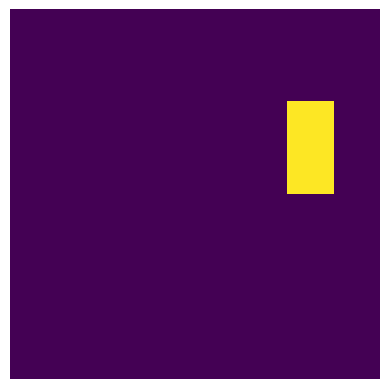

In [3]:
generate_bitmap_with_two_connected_goals()

## Romeo and Juliet (with relative positions)

Let's try to train two agents to run towards each other as quickly as possible, no matter their starting positions.

[(4, 0), (7, 4)]

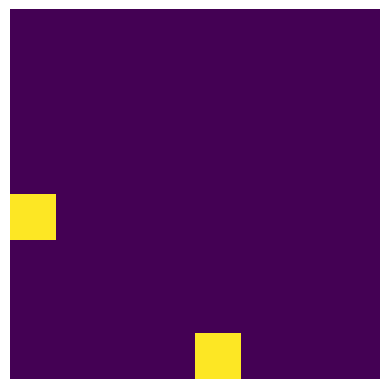

In [4]:
def spawn_agents_in_grid(grid_size=(8, 8), num_agents=2, show=False):
    agent_positions = []

    while len(agent_positions) < num_agents:
        position = tuple(np.random.randint(0, grid_size[0], 2))
        bitmap = np.zeros((8, 8), dtype=int)

        # Ensure the position is unique
        if position not in agent_positions:
            agent_positions.append(position)

    for pos in agent_positions:
        bitmap[pos[0]][pos[1]] = 1

    if show:
        plt.imshow(bitmap)
        plt.axis('off')
        plt.show

    return bitmap, agent_positions

_, agent_positions = spawn_agents_in_grid(show=True)
agent_positions

In [5]:
class SARSAAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1, epsilon_decay=0.995, epsilon_min=0.01):
        self.q_table = np.zeros((8, 8, 8, 8, 9))  # 8x8 grid, 8x8 relative positions, and 9 possible actions
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate of exploration
        self.epsilon_min = epsilon_min  # Minimum exploration rate
        
        # Define the action space
        self.actions = ['up', 'down', 'left', 'right', 'up_left', 'up_right', 'down_left', 'down_right', 'stay']

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            # Explore: choose a random action
            return np.random.choice(self.actions)
        else:
            # Exploit: choose the best action from Q-table
            x, y, dx, dy = state
            return self.actions[np.argmax(self.q_table[x, y, dx, dy])]

    def get_next_state(self, current_state, action):
        # This function returns the next state based on the current state and action
        x, y = current_state
        if action == 'up':
            return (max(x-1, 0), y)
        elif action == 'down':
            return (min(x+1, 7), y)
        elif action == 'left':
            return (x, max(y-1, 0))
        elif action == 'right':
            return (x, min(y+1, 7))
        elif action == 'up_left':
            return (max(x-1, 0), max(y-1, 0))
        elif action == 'up_right':
            return (max(x-1, 0), min(y+1, 7))
        elif action == 'down_left':
            return (min(x+1, 7), max(y-1, 0))
        elif action == 'down_right':
            return (min(x+1, 7), min(y+1, 7))
        else:
            return current_state

    def action_index(self, action):
        return self.actions.index(action)

    def update(self, current_state, action, reward, next_state, next_action):
        # Convert actions to their index in the Q-table
        action_index = self.action_index(action)
        next_action_index = self.action_index(next_action)

        # Perform the SARSA update to the Q-table
        current_q = self.q_table[current_state + (action_index,)]
        next_q = self.q_table[next_state + (next_action_index,)]
        target_q = reward + self.gamma * next_q
        self.q_table[current_state + (action_index,)] += self.alpha * (target_q - current_q)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [6]:
def calculate_relative_position(agent_pos, other_agent_pos):
    dx = other_agent_pos[0] - agent_pos[0]
    dy = other_agent_pos[1] - agent_pos[1]
    return (dx, dy)

def is_in_moore_neighborhood(pos1, pos2):
    """Check if two positions are in each other's Moore neighborhood."""
    dx = abs(pos1[0] - pos2[0])
    dy = abs(pos1[1] - pos2[1])
    return dx <= 1 and dy <= 1

def train_agents(agent1, agent2, num_episodes=1000, num_steps=100):
    for episode in range(num_episodes):
        # Initialize the positions of both agents
        _, positions = spawn_agents_in_grid()
        
        # pos of 2 with respect to 1
        relative_pos2 = calculate_relative_position(positions[0], positions[1])
        # pos of 1 with respect to 2
        relative_pos1 = calculate_relative_position(positions[1], positions[0])

        state1 = positions[0] + relative_pos2
        state2 = positions[1] + relative_pos1

        action1 = agent1.choose_action(state1)
        action2 = agent2.choose_action(state2)

        for step in range(num_steps):  # Limit the number of steps per episode
            next_position1 = agent1.get_next_state(positions[0], action1)
            next_position2 = agent2.get_next_state(positions[1], action2)

            next_relative_pos2 = calculate_relative_position(next_position1, next_position2)
            next_relative_pos1 = calculate_relative_position(next_position2, next_position1)

            # check if agents are in each other's Moore neighborhood
            reward = 0 if is_in_moore_neighborhood(next_position1, next_position2) else -1

            next_state1 = next_position1 + next_relative_pos2
            next_state2 = next_position2 + next_relative_pos1

            next_action1 = agent1.choose_action(next_state1)
            next_action2 = agent2.choose_action(next_state2)

            agent1.update(state1, action1, reward, next_state1, next_action1)
            agent2.update(state2, action2, reward, next_state2, next_action2)

            positions = (next_position1, next_position2)
            relative_pos1, relative_pos2 = next_relative_pos1, next_relative_pos2
            action1, action2 = next_action1, next_action2

            if reward == 0:
                break  # Agents are in each other's Moore neighborhood, end the episode

In [7]:
romeo = SARSAAgent()
juliet = SARSAAgent()

train_agents(romeo, juliet, num_episodes=100_000)

### Visualisation

In [8]:
def make_video(agent1, agent2, filename='two_agents_movement.mp4'):
    grid, positions = spawn_agents_in_grid()
    # Set up the video writer with a higher FPS to slow down the movement
    writer = imageio.get_writer("videos/" + filename, fps=3)

    # Increase the size of the grid for better visibility
    scale_factor = 50  # Increase this if you want even larger frames
    large_grid = np.kron(grid, np.ones((scale_factor, scale_factor)))

    for step in range(100):  # Assume a maximum of 100 steps
        # Update the grid with the current agent position (set to 1 for white)
        grid[positions[0]] = 1
        grid[positions[1]] = 1
        large_grid = np.kron(grid, np.ones((scale_factor, scale_factor)))  # Scale up
        frame = (large_grid * 255).astype(np.uint8)  # Convert to an image
        frame = np.stack((frame,) * 3, axis=-1)  # Convert to RGB

        # Repeat each frame three times
        for _ in range(3):
            writer.append_data(frame)

        # Set the agent's previous position back to 0 (black)
        grid[positions[0]] = 0
        grid[positions[1]] = 0

        relative_pos2 = calculate_relative_position(positions[0], positions[1])
        # pos of 1 with respect to 2
        relative_pos1 = calculate_relative_position(positions[1], positions[0])

        # Move the agent
        action1 = agent1.choose_action(positions[0] + relative_pos2)
        action2 = agent2.choose_action(positions[1] + relative_pos1)
        next_position1 = agent1.get_next_state(positions[0], action1)
        next_position2 = agent2.get_next_state(positions[1], action2)

        # If the agent reaches the goal, update the grid and append the final frames
        if is_in_moore_neighborhood(next_position1, next_position2):
            grid[next_position1] = 1
            grid[next_position2] = 1
            large_grid = np.kron(grid, np.ones((scale_factor, scale_factor)))
            final_frame = (large_grid * 255).astype(np.uint8)
            final_frame = np.stack((final_frame,) * 3, axis=-1)
            for _ in range(3):
                writer.append_data(final_frame)
            break  # Break after showing the final move

        # Update the start position for the next step
        positions[0] = next_position1
        positions[1] = next_position2

    writer.close()  # Close the writer to finalize the video

    return "videos/" + filename


In [9]:
Video(make_video(SARSAAgent(), SARSAAgent(), filename="two_untrained.mp4"))

In [10]:
Video(make_video(romeo, juliet, filename="two_trained.mp4"))

So, after training for 100x longer than in the single agent case, we get something that looks quite good, even though (1) the agents move apart before coming closer and (2) this might very well be a stochastic fluke...

### A more robust testing environment

In [11]:
# baseline
untrained1, untrained2 = SARSAAgent(), SARSAAgent()

# trained ones
trained1, trained2 = SARSAAgent(), SARSAAgent()
train_agents(trained1, trained2, num_episodes=100_000)

In [12]:
def check_trained_better(trained1, trained2, untrained1, untrained2, m):
    steps_untrained = np.zeros(m)
    steps_trained = np.zeros(m)

    # increase m for higher statistical significance
    for i in range(m):
        _, positions = spawn_agents_in_grid()
        
        positions_t = positions # trained
        positions_u = positions # untrained
        for stepn in range(100):
            #trained
            relative_pos2_t = calculate_relative_position(positions_t[0], positions_t[1])
            relative_pos1_t = calculate_relative_position(positions_t[1], positions_t[0])
            relative_pos2_u = calculate_relative_position(positions_u[0], positions_u[1])
            relative_pos1_u = calculate_relative_position(positions_u[1], positions_u[0])

            action1_t = trained1.choose_action(positions_t[0] + relative_pos2_t)
            action2_t = trained2.choose_action(positions_t[1] + relative_pos1_t)
            action1_u = untrained1.choose_action(positions_u[0] + relative_pos2_u)
            action2_u = untrained2.choose_action(positions_u[1] + relative_pos1_u)

            next_position1_t = trained1.get_next_state(positions_t[0], action1_t)
            next_position2_t = trained2.get_next_state(positions_t[1], action2_t)
            next_position1_u = untrained1.get_next_state(positions_u[0], action1_u)
            next_position2_u = untrained2.get_next_state(positions_u[1], action2_u)

            # if the trained agents reach the goal => append steps, add one more and append to untrained as well, so that it's greater than
            if is_in_moore_neighborhood(next_position1_t, next_position2_t):
                steps_trained[i] = stepn
                steps_untrained[i] = stepn + 10
                break

            # as above, in the case the untrained agents reach the goal quicker (this should happen very rarely!)
            if is_in_moore_neighborhood(next_position1_u, next_position2_u):
                steps_untrained[i] = stepn
                steps_trained[i] = stepn + 10
                break
            
            positions_t[0] = next_position1_t
            positions_t[1] = next_position2_t

            positions_u[0] = next_position1_u
            positions_u[1] = next_position2_u

    return steps_trained, steps_untrained

In [13]:
m = 1000
trained, untrained = check_trained_better(trained1, trained2, untrained1, untrained2, m)

In [14]:
is_trained_worse = trained > untrained
is_trained_worse

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [15]:
n_trained_better = is_trained_worse.size - np.count_nonzero(is_trained_worse)

n_trained_better / m

0.998

Well, that's a plaesant surprise! The trained model is better >99% of the time! Even though we're using simple SARSA, even though the problem is non-stationary.

Naturally, this happens, in great part, because of how simple the environment is.